<a href="https://colab.research.google.com/github/tanmayite94/MedicalCharges/blob/master/MedicineCharges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [178]:
%%html
<link rel="stylesheet" href="/nbextensions/google.colab/tabbar.css">
<div class='goog-tab'>
  Some content
</div>

In [179]:
import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

class Handler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200)
    # If the response should not be cached in the notebook for
    # offline access:
    # self.send_header('x-colab-notebook-cache-control', 'no-cache')
    self.end_headers()
    self.wfile.write(b'''
      document.querySelector('#output-area').appendChild(document.createTextNode('Script result!'));
    ''')

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Display some HTML referencing the resource.
display(IPython.display.HTML('<script src="https://localhost:{port}/"></script>'.format(port=port)))

In [0]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# get the data
import os
import urllib

download_path = "https://raw.githubusercontent.com/tanmayite94/InsuranceCostPred/master/insurance.csv"

if not os.path.exists('/content/datasets'):
    os.makedirs('/content/datasets')
    file_path = '/content/datasets/insurance.csv'
    urllib.request.urlretrieve(download_path, file_path)

In [182]:
import pandas as pd

insurance = pd.read_csv(file_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [183]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


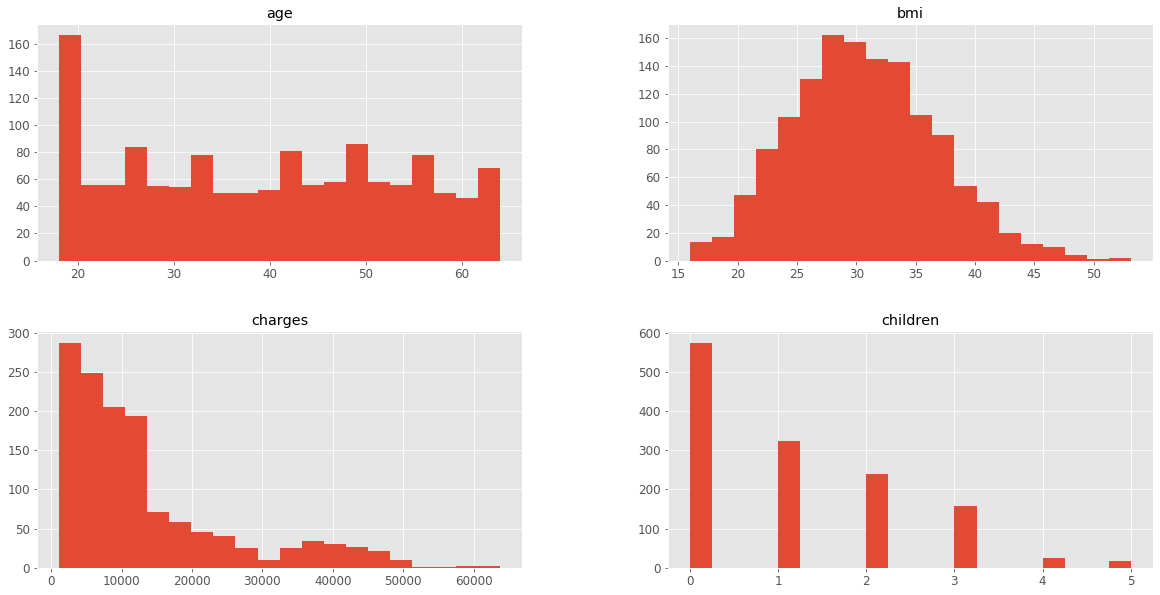

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
insurance.hist(bins=20, figsize=(20, 10))
plt.show()

In [0]:
# split the train set and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

# Visualize Data


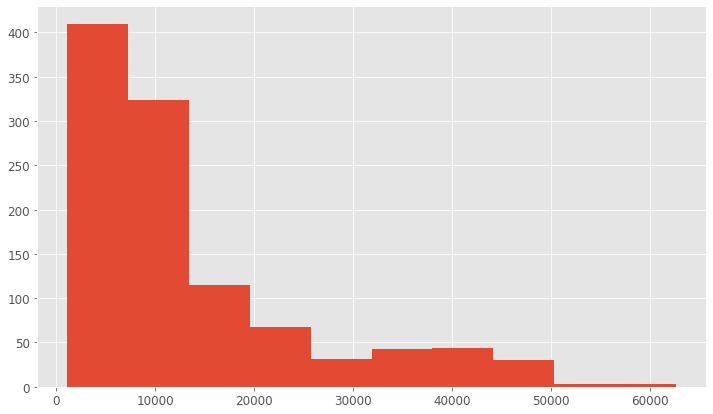

In [186]:
# Distribution of charges
train_set['charges'].hist(figsize=(12, 7))

more than half people incure charges less than 20k. let's check the distribution for smokers and non-smokers. First let's see how many smokes.

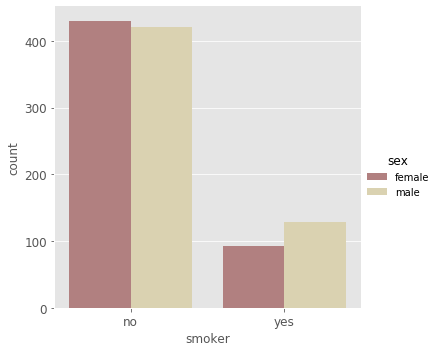

In [187]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=train_set)

There are more than 800 patients who do not smoke and around 200 who smokes. Also in the one who smokes male outnumbers the female.

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

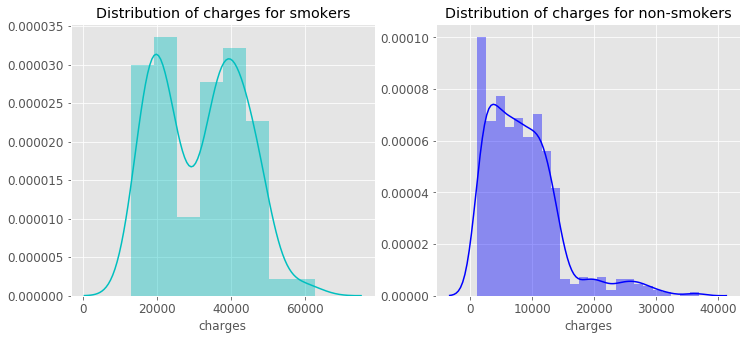

In [188]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(train_set[(train_set.smoker == 'yes')]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(train_set[(train_set.smoker == 'no')]['charges'],color='b', ax=ax)
ax.set_title('Distribution of charges for non-smokers')

These plot shows that medical cost of patients who smoke is higher than that of people who do not smoke

Text(0.5, 1, 'Charges distribution for smokers and non-smokers')

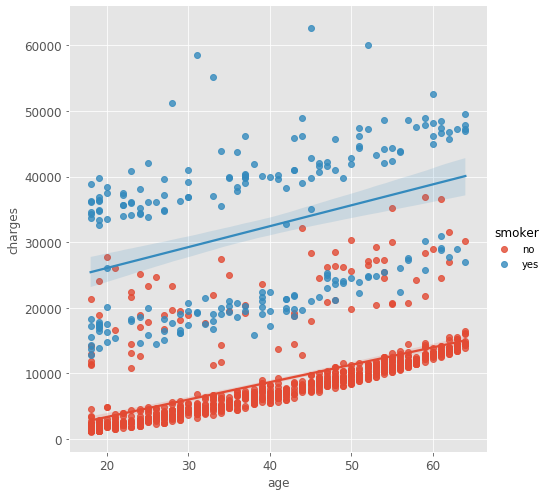

In [189]:
sns.lmplot(x="age", y="charges", hue="smoker", data=train_set,  height = 7)
ax.set_title('Charges distribution for smokers and non-smokers')

Let's see if bmi affects the medical cost of patients. BMI over 30 is considered obese.

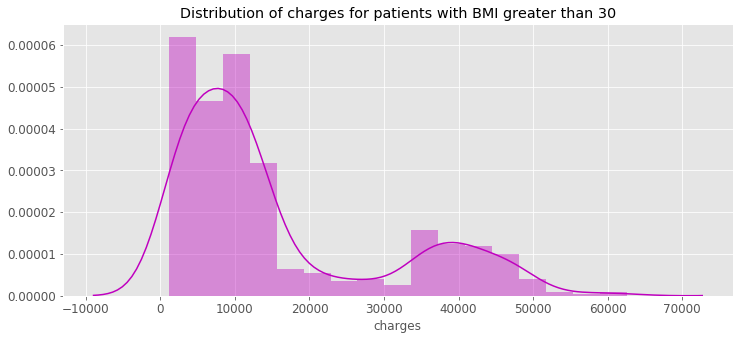

In [190]:
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(train_set[(train_set.bmi >= 30)]['charges'], color = 'm')

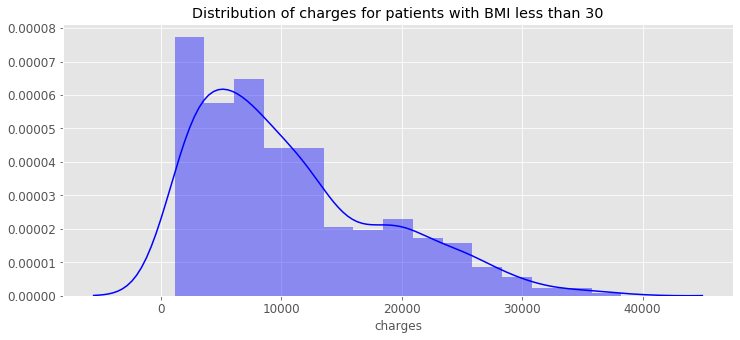

In [191]:
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(train_set[(train_set.bmi < 30)]['charges'], color = 'b')

Patients with BMI over 30 do spend more than patients with lower BMI.

In [192]:
# set train set, test set aside
insurance = train_set.drop("charges", axis=1)
insurance_labels = train_set["charges"].copy()
insurance_labels.head()

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
Name: charges, dtype: float64

# Preprocessing numerical and text data.

In [0]:
import numpy as np

# separate categorial features from numerical features
insurance_num = list(insurance.select_dtypes(include=[np.number]))
insurance_cat = list(insurance.select_dtypes(include=[np.object]))

In [0]:
# StandardScaler is used for standardization and OneHotEncoder to transform the categorial attributes
# to binary form.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer(
    [('cat', OneHotEncoder(), insurance_cat),
     ('num', StandardScaler(), insurance_num)]
)

insurance_prepared = full_pipeline.fit_transform(insurance)

# save the processed attributes in a list we need it later
cat_attribs = []
temp = full_pipeline.named_transformers_['cat'].categories_ # names of the transformed features
for item in temp:
    for cat in item:
        cat_attribs.append(cat)

num_attribs = full_pipeline.transformers_[1][2]

# Select and train model

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [196]:
# train a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(insurance_prepared, insurance_labels)
lin_reg.score(insurance_prepared, insurance_labels)

0.7394252296075601

In [197]:
from sklearn.metrics import mean_squared_error, r2_score

insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6132.674815701483

In [198]:
# check cross-validation on linear regression
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6343.01865761 5662.68854609 5988.07811636 6829.18055041 5891.94432448]
Mean: 6142.982038991172
Standard deviation: 407.0823122016718


In [199]:
# let's try a decision tree model
from sklearn.tree import DecisionTreeRegressor

# choose criterion mae because it is less sensitive to outliers than mse.
tree_reg = DecisionTreeRegressor(random_state=42, criterion='mae')

tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [200]:
# check mean squared error on decision tree
insurance_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

494.20598375812835

clearly the decision tree model is better fitting the data than linear regression.but we have to evaluate decision tree model first by cross-validation.

In [201]:
# check cross-validation on decision tree
scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [6053.79696242 6005.75981727 6943.94426396 6406.71996614 7087.60420284]
Mean: 6499.565042526016
Standard deviation: 445.96769758703005


Decision tree algorithm was overfitting the data, hence we need to tune the hyperparameters

# Fine tune your model

In [223]:
# try different combinations of hyperparameters
from sklearn.model_selection import GridSearchCV

params_grid = [
              {'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [15, 20, 25]}
               ]

tree_reg = DecisionTreeRegressor(random_state=42, criterion='mae')
grid_search = GridSearchCV(tree_reg, params_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(insurance_prepared, insurance_labels)
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 20}

In [224]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4807.416535956126 {'max_depth': 4, 'min_samples_split': 15}
4807.416535956126 {'max_depth': 4, 'min_samples_split': 20}
4814.689659277122 {'max_depth': 4, 'min_samples_split': 25}
4771.144307868897 {'max_depth': 5, 'min_samples_split': 15}
4740.1800741694715 {'max_depth': 5, 'min_samples_split': 20}
4751.8781872076515 {'max_depth': 5, 'min_samples_split': 25}
4909.945516239776 {'max_depth': 6, 'min_samples_split': 15}
4748.0202377454025 {'max_depth': 6, 'min_samples_split': 20}
4774.41888937549 {'max_depth': 6, 'min_samples_split': 25}
5003.681413384168 {'max_depth': 7, 'min_samples_split': 15}
4807.704462818648 {'max_depth': 7, 'min_samples_split': 20}
4824.4219075895235 {'max_depth': 7, 'min_samples_split': 25}
5151.544264267865 {'max_depth': 8, 'min_samples_split': 15}
4884.264061221144 {'max_depth': 8, 'min_samples_split': 20}
4871.116741224871 {'max_depth': 8, 'min_samples_split': 25}


In [204]:
# check feature importance given by algorithm
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = cat_attribs + num_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.7032124468474984, 'no'),
 (0.178706898839473, 'bmi'),
 (0.11449197872396331, 'age'),
 (0.003588675589065236, 'children'),
 (0.0, 'yes'),
 (0.0, 'southwest'),
 (0.0, 'southeast'),
 (0.0, 'northwest'),
 (0.0, 'northeast'),
 (0.0, 'male'),
 (0.0, 'female')]

Decision tree gave most importance to the smoker feature and no importance to the region, children, gender features

In [209]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=100,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [225]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

4664.2369759796875